 # GOLUB use case

In [1]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

# Table of contents
* [Dataset](#dataset)
    * [Top 100](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomeR)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [2]:
load("data/leukemia.RData")
golub = as.data.frame(leukemia)
head(golub)

,Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,⋯,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,⋯,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
2,T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,⋯,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
3,T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,⋯,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
4,B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,⋯,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
5,B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,⋯,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
6,T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,⋯,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


Three types of classes within the dataset: **B**, **T** and **M**.

In [3]:
unique(golub["Class"])

,Class
,<fct>
1,B
2,T
28,M


*Further information regarding GOLUB in [cancerclass](https://rdrr.io/bioc/cancerclass/man/GOLUB.html) package.*

Here, we prepare the GOLUB dataset for the analysis, in order to do so, we remove non-numeric columns:

In [4]:
golub["Class"] = NULL # leukemia
golub["sample"] = NULL
golub["type"] = NULL
golub["FAB"] = NULL
golub["gender"] = NULL

In [5]:
head(golub)

,Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,⋯,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,⋯,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
2,T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,⋯,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
3,T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,⋯,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
4,B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,⋯,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
5,B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,⋯,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
6,T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,⋯,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


## Top 100 <a class="anchor" id="top"></a>
We now filter the metrics for including only the top 100 with the greatest variance, as these metrics have the most significant impact on clustering.

In [6]:
variance = sort(sapply(golub[-1], var,na.rm = TRUE), decreasing = TRUE)  # Sorted gene variance
gene_var = as.data.frame(variance)
gene_var["gene"] = rownames(gene_var)
head(gene_var)

,variance,gene
,<dbl>,<chr>
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [7]:
top_number = 100
top_genes = gene_var[c(1:top_number), ]
head(top_genes)

,variance,gene
,<dbl>,<chr>
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [8]:
gene_list = as.list(top_genes["gene"])
top_gene_list = unlist(setdiff(gene_list, names(golub)))
# Top 100 metrics (genes)
top_gene_list

gene1                     gene2                     gene3 
         "X82240_rna1_at"               "M27891_at"             "M26311_s_at" 
                    gene4                     gene5                     gene6 
"AFFX.HUMRGE.M10098_5_at"             "Y00787_s_at"               "M84526_at" 
                    gene7                     gene8                     gene9 
              "M19507_at"               "D88270_at"             "M63438_s_at" 
                   gene10                    gene11                    gene12 
       "M28130_rna1_s_at" "AFFX.HUMRGE.M10098_M_at"               "M12886_at" 
                   gene13                    gene14                    gene15 
         "M91036_rna1_at" "AFFX.HUMRGE.M10098_3_at"        "AFFX.M27830_5_at" 
                   gene16                    gene17                    gene18 
            "X00437_s_at"               "M21005_at"             "M87789_s_at" 
                   gene19                    gene20                    gene21 
              "M58459_at"               "M11722_at"          "U01317_cds4_at" 
                   gene22                    gene23                    gene24 
              "M21305_at"             "M27783_s_at"             "L33930_s_at" 
                   gene25                    gene26                    gene27 
              "J04164_at"               "J04456_at"               "X58529_at" 
                   gene28                    gene29                    gene30 
            "U89922_s_at"             "M21119_s_at"             "M25079_s_at" 
                   gene31                    gene32                    gene33 
              "M89957_at"          "Z83821_cds2_at"               "M57710_at" 
                   gene34                    gene35                    gene36 
              "M38690_at"             "M57466_s_at"               "X05908_at" 
                   gene37                    gene38                    gene39 
              "X77737_at"               "M34516_at"               "M91438_at" 
                   gene40                    gene41                    gene42 
         "M96326_rna1_at"          "U05259_rna1_at"             "X76223_s_at" 
                   gene43                    gene44                    gene45 
              "K01911_at"               "D88422_at"             "U05255_s_at" 
                   gene46                    gene47                    gene48 
              "X04500_at"      "HG3576.HT3779_f_at"               "X95735_at" 
                   gene49                    gene50                    gene51 
            "X64072_s_at"               "D83735_at"               "D83920_at" 
                   gene52                    gene53                    gene54 
              "M21904_at"               "J03909_at"           "AF000424_s_at" 
                   gene55                    gene56                    gene57 
              "Z23090_at"               "D13639_at"               "J04102_at" 
                   gene58                    gene59                    gene60 
              "U57341_at"               "M15395_at"          "Z84721_cds2_at" 
                   gene61                    gene62                    gene63 
              "M38591_at"               "D87433_at"               "U46499_at" 
                   gene64                    gene65                    gene66 
              "X17042_at"               "M63573_at"               "U09770_at" 
                   gene67                    gene68                    gene69 
            "U20734_s_at"               "M94345_at"             "M23178_s_at" 
                   gene70                    gene71                    gene72 
         "M11717_rna1_at"             "M57731_s_at"             "J03077_s_at" 
                   gene73                    gene74                    gene75 
         "HG987.HT987_at"               "U02687_at"               "L08895_at" 
                   gene76                    gene77                   

In [9]:
top_golub = golub[, top_gene_list]
top_golub["labels"] = rownames(top_golub)
top_golub = top_golub[ , c("labels", names(top_golub)[names(top_golub) != "labels"])] 

The dataframe `top_golub` contains 100 genes (metrics) which provides the most variance.

In [10]:
head(top_golub)

,labels,X82240_rna1_at,M27891_at,M26311_s_at,AFFX.HUMRGE.M10098_5_at,Y00787_s_at,M84526_at,M19507_at,D88270_at,M63438_s_at,⋯,Z69881_at,M16279_at,M21624_at,U02020_at,M16336_s_at,L19686_rna1_at,X65965_s_at,X03934_at,M28826_at,M30703_s_at
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.16170,2.48144,2.00000,4.16250,2.52244,2.0000,2.0000,3.29336,3.75143,⋯,3.24699,3.48841,2.43457,2.24551,2.00000,2.89487,2.83059,2.79449,2.00000,2
2,2,2.00000,3.13290,3.64856,2.78888,3.72795,2.0000,2.0000,2.29667,3.68646,⋯,3.30428,4.01932,4.07185,3.05690,3.31513,3.86094,3.40926,3.88434,2.00000,2
3,3,2.00000,2.40483,2.88930,3.75351,2.47857,2.0000,2.0000,2.76268,2.00000,⋯,3.55096,3.97211,2.26007,2.06070,3.56384,3.79616,2.52763,4.05312,3.94379,2
4,4,3.71659,2.00000,2.19590,3.68574,2.38202,2.0000,2.0000,3.68851,2.00000,⋯,2.91803,3.17406,2.00000,2.00000,2.00000,2.79449,2.43457,2.67578,2.00000,2
5,5,3.77772,2.00000,3.33746,3.10857,2.00000,2.4624,2.9722,3.52930,2.83696,⋯,3.17493,3.67596,2.00000,2.33646,2.00000,3.78810,2.56820,2.53782,2.00000,2
6,6,2.00000,3.06744,3.20737,3.61784,2.33244,2.0000,2.0000,2.00000,2.00000,⋯,3.41597,3.94655,2.00000,2.00000,3.50947,3.55425,2.50651,3.85485,3.69522,2


# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomeR"></a>

In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `rskc`.

In [11]:
seed = 13606
k.range=c(3,10)
optimal_k = 3 # From Clara optimal k execution
cbi = "rskc"
top_golub = golub
colnames(top_golub)[colnames(top_golub) == 'Case'] <- 'Description'

Automatic computation of $L_1$ bound and $alpha$ accordingot the optimal $k$. The optimal $k$ is retrieved from the `kmeans` analysis in the notebook [golub.ipynb](https://github.com/neobernad/evaluomeR/blob/master/notebooks/use_cases/golub.ipynb). 

In [12]:
L1 = getRSKCL1Boundry(top_golub, k=optimal_k, seed=seed)
alpha = getRSKCAlpha(top_golub, k=optimal_k, L1=L1, seed)

Computing best L1 boundry with 'sparcl::KMeansSparseCluster.permute'

Best L1 found is: 7.24137931034483, using floor: 7

Running stability and quality indexes with alpha=0



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

Running stability and quality indexes with alpha=0.05



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

Running stability and quality indexes with alpha=0.1



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3



Data loaded.
Number of rows: 72
Num

Stability calculation with $k \in [3,10]$ and `clara`:

In [13]:
stab_range = stabilityRange(data=top_golub, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi, L1=L1, alpha=alpha)
stab = standardizeStabilityData(stab_range)



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [14]:
rownames(stab) = c("stab_rskc")
stab$Metric = rownames(stab)
stab$Method = "rskc"
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

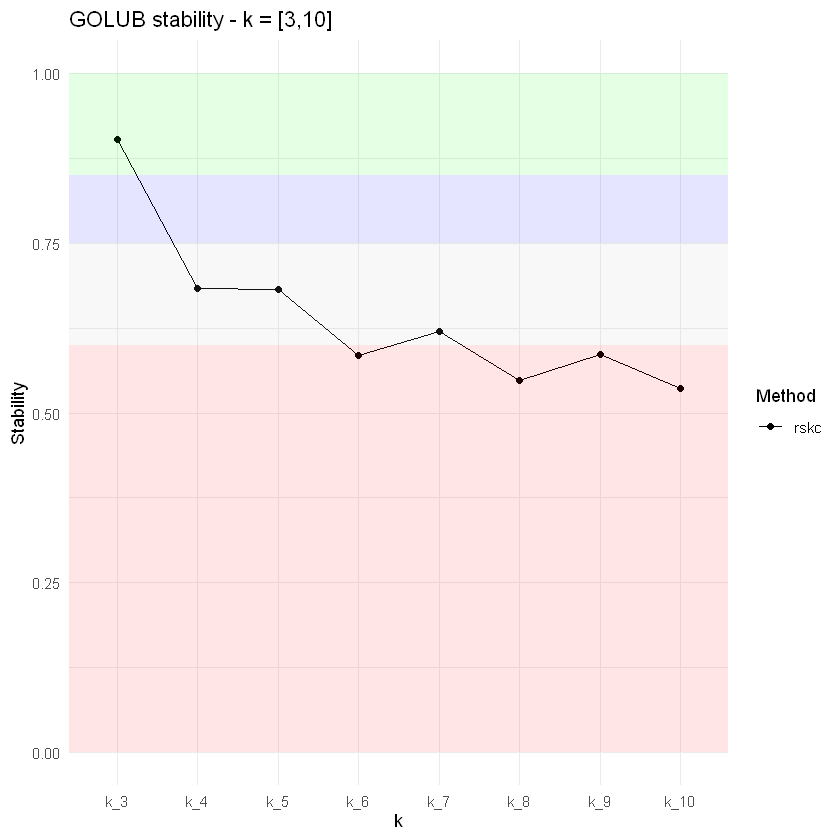

In [15]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")



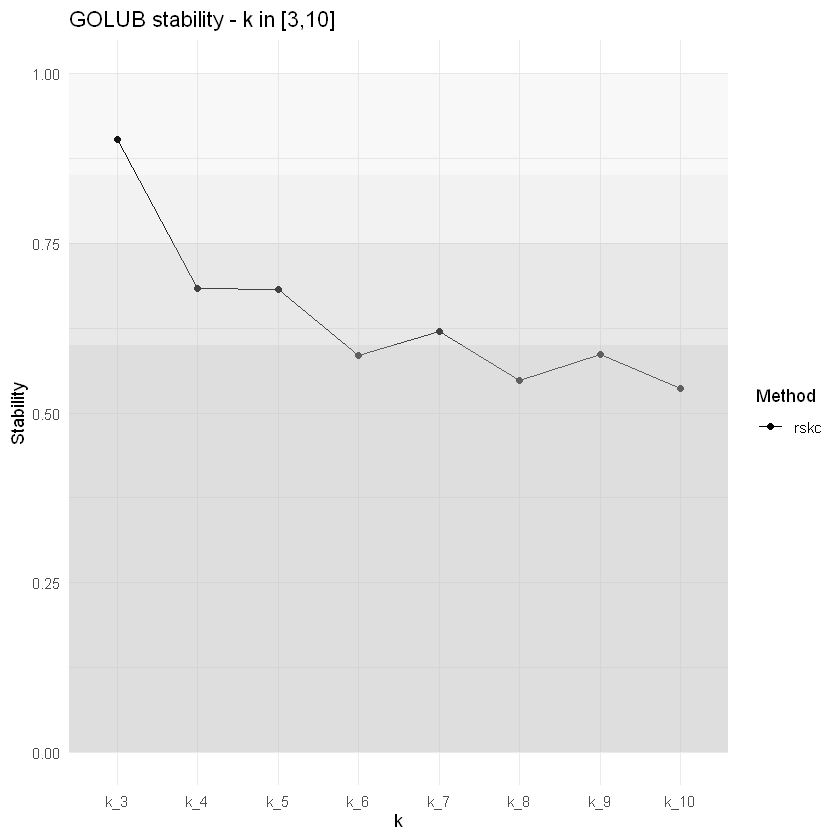

In [16]:
# Grayscale

# Define the grayscale palette
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Quality calculation with $k \in [3,10]$ and `RSKC`.

In [17]:
qual_range = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi, alpha=alpha, L1=L1)
qual = standardizeQualityData(qual_range)



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [18]:
rownames(qual) = c("qual_rskc")
qual$Metric = rownames(qual)
qual$Method = cbi
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

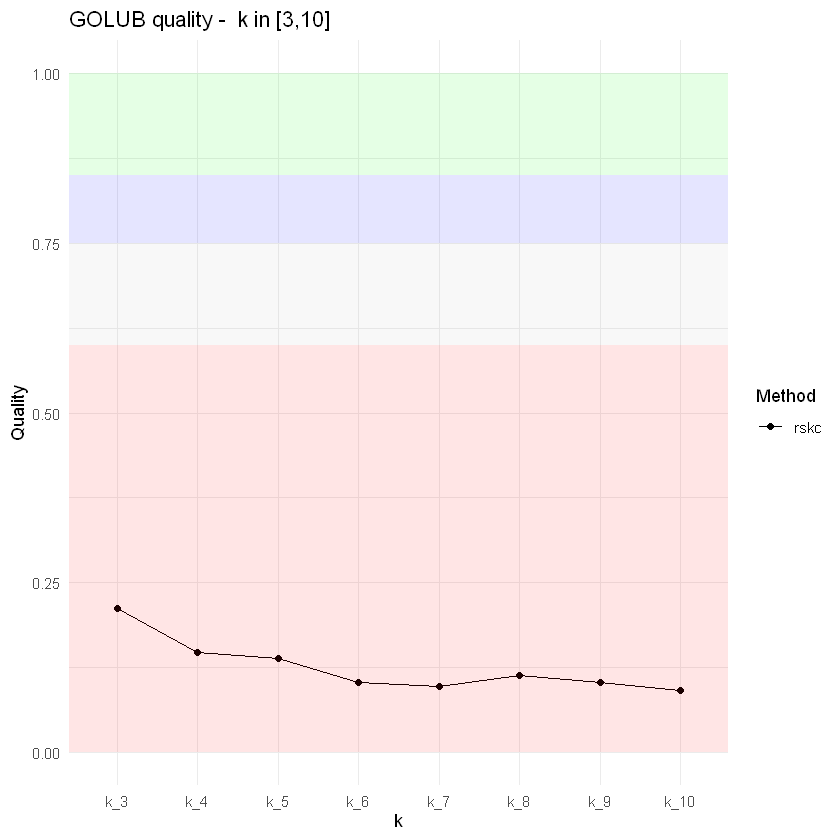

In [19]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")

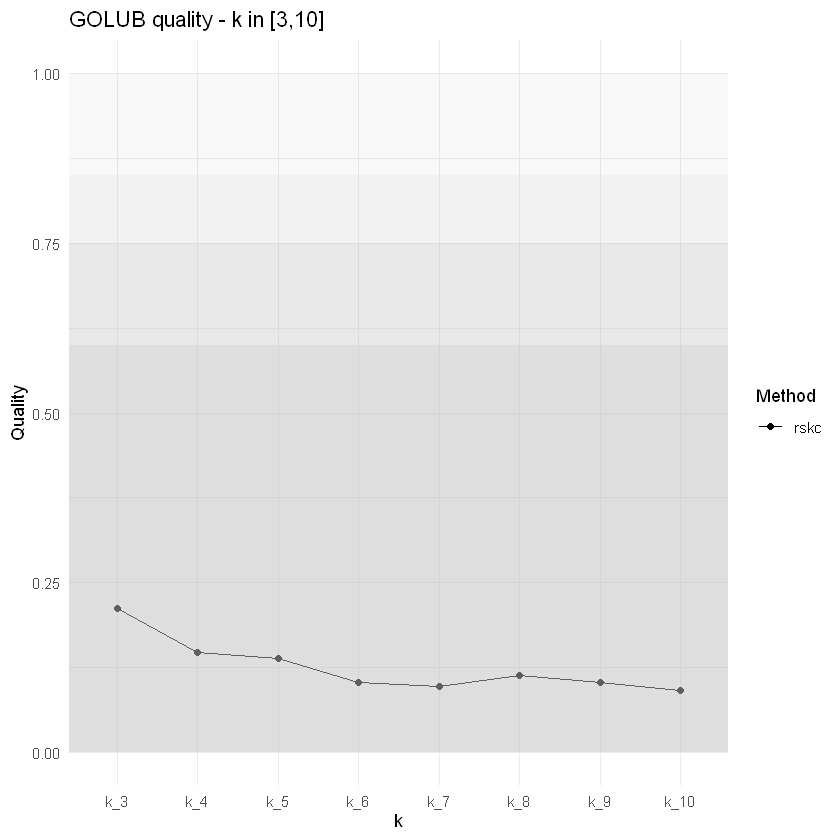

In [20]:
# Grayscale

grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")


p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [21]:
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))

Processing metric: all_metrics


	Maximum stability and quality values matches the same K value: '3'




[1] "Optimal k: 3"


In [22]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Quality in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "Stabilities and qualities per k with 'rskc' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_rskc,0.9027141,0.682893,0.6815697,0.5848204,0.6200326,0.5478393,0.5862544,0.535579,stab_rskc,rskc


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_rskc,0.2120025,0.1461911,0.1380921,0.1032455,0.09631843,0.1133916,0.1020238,0.09056753,qual_rskc,rskc


[1] "Stabily in k=3: 0.902714126922497"
[1] "Quality in k=3: 0.212002512211207"


# Clusters

In [23]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
    
  qual_df = as.data.frame(assay(qualityResult))
    

  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [24]:
cluster_individuals = individuals_per_cluster(assay(qual_range[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}

[1] "CBI: rskc - k: 3"
[1] "Cluster 1 : T1,T2,T3,T4,T5,T6,T7,B10,T8,AML10,B32,T9,AML22"
[1] ""
[1] "Cluster 2 : AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML11,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML23,AML24,AML25"
[1] ""
[1] "Cluster 3 : B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B33,B34,B35,B36,B37,B38"
[1] ""


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [25]:
top_golub["inCluster"] = as.numeric(cluster_individuals$InCluster)
pca_matrix = top_golub %>% select(-Description, -inCluster)
pca_result <- prcomp(pca_matrix, scale. = TRUE)
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_golub$inCluster)
pca_df$Individual <- top_golub$Description
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,Cluster,Individual
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,5.6600497,-0.9403696,0.6000786,-1.1199127,2.6200577,-4.0006269,0.6478649,-1.5370026,0.8663557,-2.17861488,⋯,-0.07198869,-0.10318543,-0.1122364,-0.122831348,-0.09263967,0.12561612,0.14561114,9.574272e-16,3,B1
2,-2.6145853,5.2911219,-3.4964281,-6.1124251,1.5135496,-2.1009037,-0.1792254,1.3688467,0.7232899,-0.03349621,⋯,-0.16755027,0.10902101,0.1899106,0.004990702,-0.14932991,-0.03649268,0.01170500,1.183814e-15,1,T1
3,2.1354183,11.4500703,-1.7966203,0.2247835,-0.2318787,1.4493604,0.6051338,-1.4108101,1.4127356,-0.69496786,⋯,0.17767414,-0.12685695,0.1752885,-0.102442206,0.07161699,-0.05849892,-0.04429441,4.822327e-16,1,T2
4,4.9435629,-0.8109685,2.7399280,3.5519694,2.9668022,2.2383532,1.6639109,1.3761154,-0.1218088,1.29753519,⋯,0.01588035,-0.18295107,0.1511074,0.197330690,-0.01898182,0.02336472,-0.19335383,1.161529e-15,3,B2
5,1.1240684,-1.5104914,3.8906659,-0.8401832,1.7507364,2.6570295,2.4860771,-0.1088313,-0.5550100,-1.10456455,⋯,-0.27438116,-0.09281758,0.1820926,0.225872452,0.06440574,-0.19662224,0.11929858,8.971850e-16,3,B3
6,0.9140257,10.9820116,-1.1194102,-0.2948204,-0.1110053,0.8184759,1.6933997,-1.3191906,0.9914184,0.76006577,⋯,0.17655650,0.05443685,-0.1479246,0.151052951,0.23717942,0.06982347,0.30425593,1.042548e-15,1,T3


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


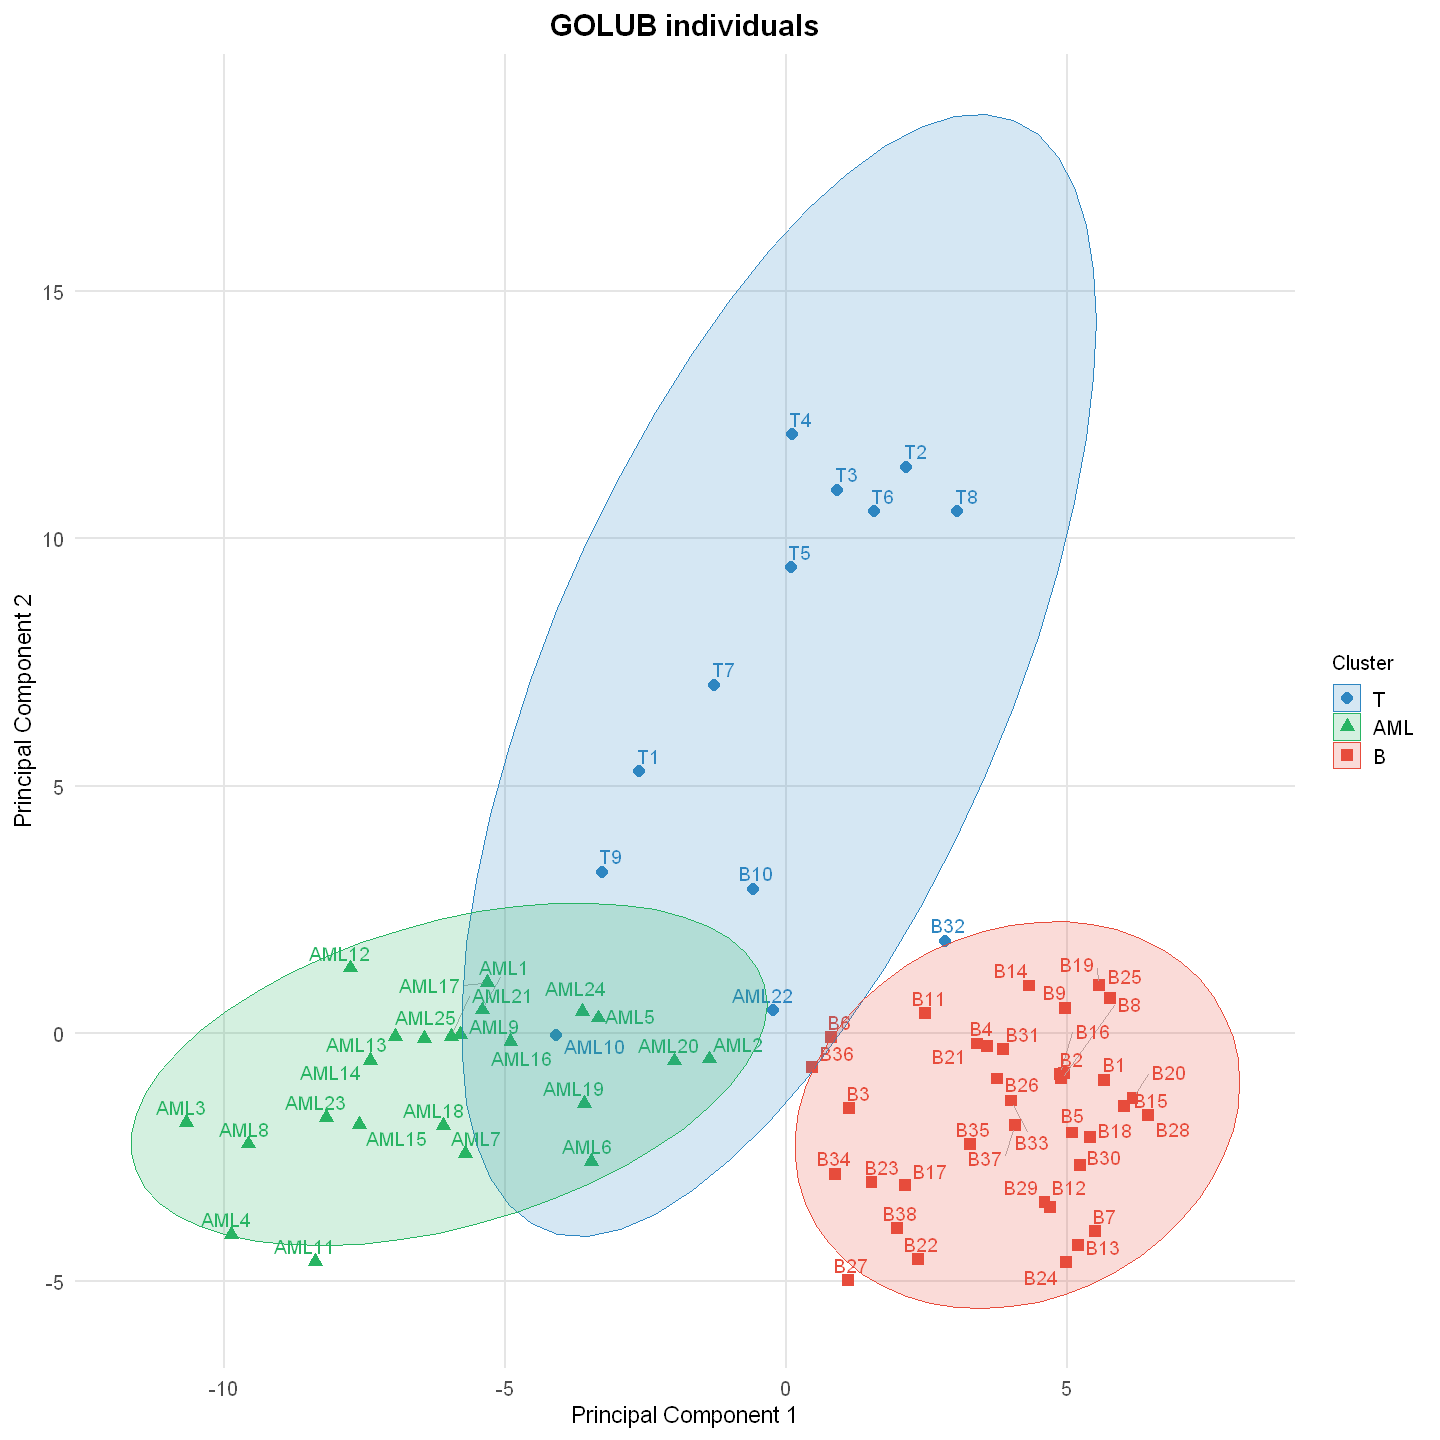

In [35]:
options(repr.plot.width=12, repr.plot.height=12)
custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes <- c(16, 17, 15, 18, 19)
cluster_labels = c("T", "AML", "B")

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels=cluster_labels) +
  scale_color_manual(values = custom_colors, labels=cluster_labels) +
  scale_fill_manual(values = custom_colors, labels=cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


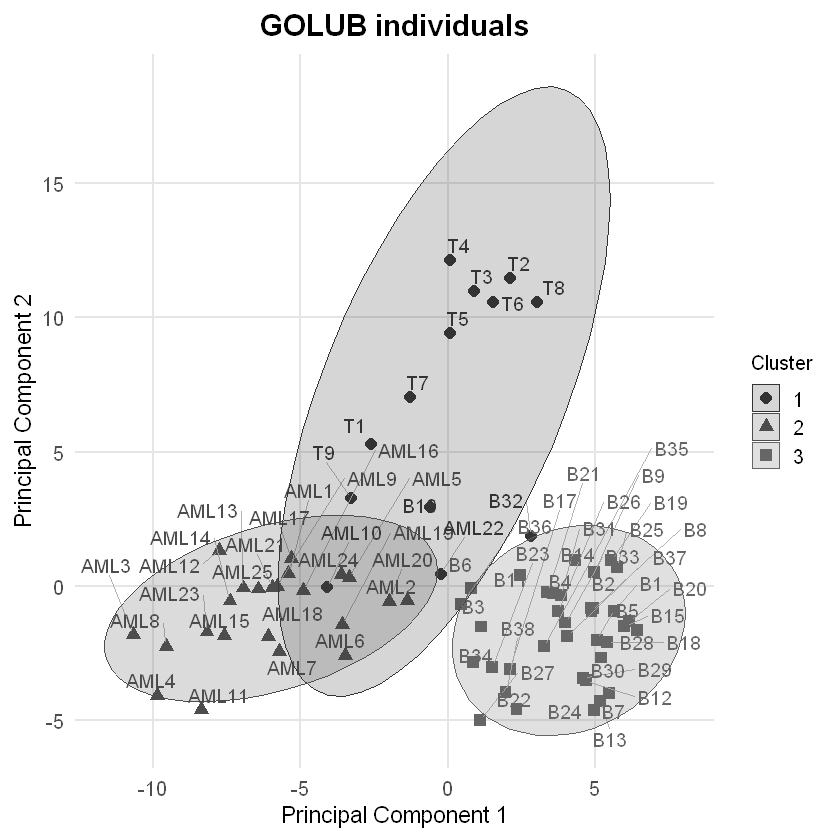

In [27]:
custom_colors <- c("gray20", "gray30", "gray40", "gray50", "black")

cluster_shapes <- c(16, 17, 15, 18, 19)

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1, 
    hjust = 1, 
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes) +
  scale_color_manual(values = custom_colors) +
  scale_fill_manual(values = custom_colors) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


# Sensitivity <a class="anchor" id="sensitivity"></a>

In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [28]:
top_golub["Class"] = as.data.frame(leukemia)["Class"]
head(top_golub)[, c("Description", "Class")]

,Description,Class
,<fct>,<fct>
1,B1,B
2,T1,T
3,T2,T
4,B2,B
5,B3,B
6,T3,T


In [29]:
level_mapping <- c("T" = 1, "M" = 2, "B" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
# Map categories with cluster number
top_golub["Class_n"] = lapply(top_golub["Class"], map_strings_to_numbers)
# Table of prediction vs actual classification
head(top_golub[, c("Description", "Class", "Class_n")])

,Description,Class,Class_n
,<fct>,<fct>,<dbl>
1,B1,B,3
2,T1,T,1
3,T2,T,1
4,B2,B,3
5,B3,B,3
6,T3,T,1


In [30]:
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(top_golub["Class_n"])))
predicted <- factor(as.vector(unlist(top_golub["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 3 1 1 3 3 1 3 3 1 1 1 3 3 1 3 3 3 3 3 3 3 3 1 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
[39] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
Levels: 1 2 3

[1] "predicted"


[1] 3 1 1 3 3 1 3 3 1 1 1 3 3 1 3 3 1 3 3 3 3 3 1 3 3 3 3 2 2 2 2 2 2 2 2 2 1 2
[39] 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 3 2 2 2 2 2 2 2 2 2 2 1 2 2 2
Levels: 1 2 3

In [31]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 100.00%"


# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [32]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 6.18%"
